In [20]:
import os
import numpy as np  
import pandas as pd
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split


import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

C:\Users\VK186001\AppData\Roaming\Python\Python37\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# 1 Read and Explore the datasets

In [21]:
Ratings_Electronics = pd.read_csv("ratings_Electronics.csv",names=["userID", "ProductID", "Rating", "Timestamp"])
Ratings_Electronics.head(7)  

,userID,ProductID,Rating,Timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
5,A1QGNMC6O1VW39,0511189877,5.0,1397433600
6,A3J3BRHTDRFJ2G,0511189877,2.0,1397433600


In [35]:
Ratings_Electronics.count()

userID       7824482
ProductID    7824482
Rating       7824482
Timestamp    7824482
dtype: int64

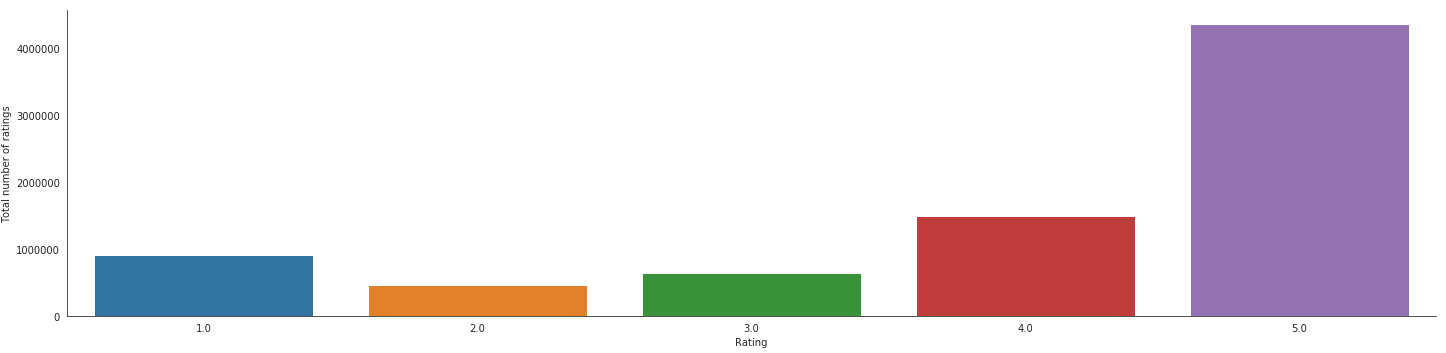

In [36]:
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=Ratings_Electronics, aspect=4.0,kind='count')
    g.set_ylabels("Total number of ratings")

# 2 Take subset of data and make it less sparse

In [71]:
Recomm_Data = Ratings_Electronics[Ratings_Electronics.groupby('userID')['Rating'].transform('size') >=50]
df_final=Recomm_Data

In [72]:
print('Number of users who have rated 50 or more items =', len(Ratings_Electronics))
print('Number of unique USERS in final data = ', Ratings_Electronics['userID'].nunique())
print('Number of unique PRODUCTS in final data = ', Ratings_Electronics['ProductID'].nunique())

Number of users who have rated 50 or more items = 7824482
Number of unique USERS in final data =  4201696
Number of unique PRODUCTS in final data =  476002


In [75]:
final_ratings_matrix = df_final.pivot(index = 'userID', columns ='ProductID', values = 'Rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


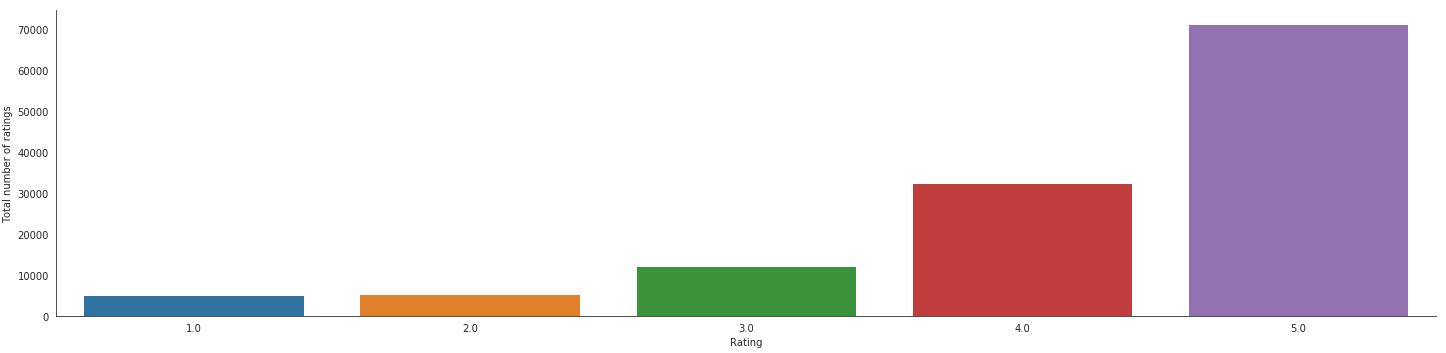

In [37]:
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=Recomm_Data, aspect=4.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [24]:
Recomm_Data.count()

userID       125871
ProductID    125871
Rating       125871
Timestamp    125871
dtype: int64

In [25]:
Recomm_Data.head(2)

,userID,ProductID,Rating,Timestamp
94,A3BY5KCNQZXV5U,0594451647,5.0,1390176000
118,AT09WGFUM934H,0594481813,3.0,1377907200


# 3. Split the data into train and test

In [27]:
train_data, test_data = train_test_split(Recomm_Data,test_size=0.30,random_state=42)
train_data.head()

,userID,ProductID,Rating,Timestamp
3406191,A30R8VFR16RE32,B003KPBRRW,5.0,1284076800
2044529,A3MMR2WDKAK0PA,B001GNBD8I,2.0,1227139200
5706800,AGOH8N902URMW,B007BXD66E,5.0,1345593600
3741724,A2RTVGR9B1M600,B004071ZXA,5.0,1302220800
4756538,A1QQA7Y92L4F9R,B0057Q49F4,5.0,1330992000


In [31]:
train_data.shape

(88109, 4)

In [32]:
test_data.shape

(37762, 4)

# 4 Build popularity based Recommendation Model

In [42]:
#Count of user_id for each unique product as recommendation score 
data_grouped = Recomm_Data.groupby('ProductID').agg({'userID': 'count'}).reset_index()
data_grouped.rename(columns = {'userID': 'score'},inplace=True)
data_grouped.head(10)

,ProductID,score
0,0594451647,1
1,0594481813,1
2,0970407998,2
3,0972683275,4
4,1400501466,6
5,1400501520,1
6,1400501776,2
7,1400532620,2
8,1400532655,6
9,140053271X,2


In [43]:
#Sort the products on recommendation score 
data_sort = data_grouped.sort_values(['score', 'ProductID'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
data_sort['Rank'] = data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = data_sort.head(10) 
popularity_recommendations

,ProductID,score,Rank
39003,B0088CJT4U,206,1.0
24827,B003ES5ZUU,184,2.0
11078,B000N99BBC,167,3.0
38250,B007WTAJTO,164,4.0
38615,B00829TIEK,149,5.0
38611,B00829THK0,137,6.0
39338,B008DWCRQW,137,7.0
21982,B002R5AM7C,128,8.0
28761,B004CLYEDC,118,9.0
22210,B002SZEOLG,113,10.0


In [45]:
# Use popularity based recommender model to make predictions
def recommend(user_id, recoModel):     
    user_recommendations = recoModel 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

In [46]:
find_recom = [6595853,4175596,1734767,3741724]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i, popularity_recommendations))    
    print("\n")

Here is the recommendation for the userId: 6595853

        userId   ProductID  score  Rank
39003  6595853  B0088CJT4U    206   1.0
24827  6595853  B003ES5ZUU    184   2.0
11078  6595853  B000N99BBC    167   3.0
38250  6595853  B007WTAJTO    164   4.0
38615  6595853  B00829TIEK    149   5.0
38611  6595853  B00829THK0    137   6.0
39338  6595853  B008DWCRQW    137   7.0
21982  6595853  B002R5AM7C    128   8.0
28761  6595853  B004CLYEDC    118   9.0
22210  6595853  B002SZEOLG    113  10.0


Here is the recommendation for the userId: 4175596

        userId   ProductID  score  Rank
39003  4175596  B0088CJT4U    206   1.0
24827  4175596  B003ES5ZUU    184   2.0
11078  4175596  B000N99BBC    167   3.0
38250  4175596  B007WTAJTO    164   4.0
38615  4175596  B00829TIEK    149   5.0
38611  4175596  B00829THK0    137   6.0
39338  4175596  B008DWCRQW    137   7.0
21982  4175596  B002R5AM7C    128   8.0
28761  4175596  B004CLYEDC    118   9.0
22210  4175596  B002SZEOLG    113  10.0


Here is the 

In [49]:
#Count of user_id for each unique product as recommendation score 
data_full_grouped = Recomm_Data.groupby('ProductID').agg({'userID': 'count'}).reset_index()
data_full_grouped.rename(columns = {'userID': 'score'},inplace=True)
data_full_grouped.head(10)

,ProductID,score
0,0594451647,1
1,0594481813,1
2,0970407998,2
3,0972683275,4
4,1400501466,6
5,1400501520,1
6,1400501776,2
7,1400532620,2
8,1400532655,6
9,140053271X,2


In [50]:
#Sort the products on recommendation score 
data_full_sort = data_full_grouped.sort_values(['score', 'ProductID'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
data_full_sort['Rank'] = data_full_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_full_recommendations = data_full_sort.head(10) 
popularity_full_recommendations

,ProductID,score,Rank
39003,B0088CJT4U,206,1.0
24827,B003ES5ZUU,184,2.0
11078,B000N99BBC,167,3.0
38250,B007WTAJTO,164,4.0
38615,B00829TIEK,149,5.0
38611,B00829THK0,137,6.0
39338,B008DWCRQW,137,7.0
21982,B002R5AM7C,128,8.0
28761,B004CLYEDC,118,9.0
22210,B002SZEOLG,113,10.0


In [52]:
find_recom = [6595853,4175596,1734767]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i, popularity_full_recommendations))    
    print("\n")

Here is the recommendation for the userId: 6595853

        userId   ProductID  score  Rank
39003  6595853  B0088CJT4U    206   1.0
24827  6595853  B003ES5ZUU    184   2.0
11078  6595853  B000N99BBC    167   3.0
38250  6595853  B007WTAJTO    164   4.0
38615  6595853  B00829TIEK    149   5.0
38611  6595853  B00829THK0    137   6.0
39338  6595853  B008DWCRQW    137   7.0
21982  6595853  B002R5AM7C    128   8.0
28761  6595853  B004CLYEDC    118   9.0
22210  6595853  B002SZEOLG    113  10.0


Here is the recommendation for the userId: 4175596

        userId   ProductID  score  Rank
39003  4175596  B0088CJT4U    206   1.0
24827  4175596  B003ES5ZUU    184   2.0
11078  4175596  B000N99BBC    167   3.0
38250  4175596  B007WTAJTO    164   4.0
38615  4175596  B00829TIEK    149   5.0
38611  4175596  B00829THK0    137   6.0
39338  4175596  B008DWCRQW    137   7.0
21982  4175596  B002R5AM7C    128   8.0
28761  4175596  B004CLYEDC    118   9.0
22210  4175596  B002SZEOLG    113  10.0


Here is the 

# Since this is a popularity-based recommender model, recommendations remain the same for all users. We predict the products based on the popularity. It is not personalized to particular user.
Train/Test Or Model accuracy is not required in popularity-based recommender model

# 5 Build Collaborative Filtering model.

In [53]:
train_data.shape

(88109, 4)

In [54]:
test_data.shape

(37762, 4)

In [55]:
df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.head()

,index,userID,ProductID,Rating,Timestamp
0,3406191,A30R8VFR16RE32,B003KPBRRW,5.0,1284076800
1,2044529,A3MMR2WDKAK0PA,B001GNBD8I,2.0,1227139200
2,5706800,AGOH8N902URMW,B007BXD66E,5.0,1345593600
3,3741724,A2RTVGR9B1M600,B004071ZXA,5.0,1302220800
4,4756538,A1QQA7Y92L4F9R,B0057Q49F4,5.0,1330992000


In [59]:
#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item' 
pivot_df = df_CF.pivot(index = 'userID', columns ='ProductID', values = 'Rating').fillna(0)
pivot_df.shape
pivot_df.head()

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8,user_index
userID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [61]:
pivot_df.set_index(['user_index'], inplace=True)

# Actual ratings given by users
pivot_df.head()

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# SVD Method

In [62]:
# SVD is best to apply on a large sparse matrix

In [63]:
from scipy.sparse.linalg import svds
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [64]:
user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [101]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [66]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 2
num_recommendations = 10
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 2):

                   user_ratings  user_predictions
Recommended Items                                
B000N99BBC                  0.0          1.464528
B00829TIEK                  0.0          1.271871
B004CLYEDC                  0.0          1.251298
B00829THK0                  0.0          1.097851
B0034CL2ZI                  0.0          0.803442
B00834SJSK                  0.0          0.801665
B00829TIA4                  0.0          0.798920
B004CLYEFK                  0.0          0.751124
B00834SJNA                  0.0          0.746606
B004T9RR6I                  0.0          0.721282


# 6.Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error(RMSE) on predictions made on the test data.) 

In [81]:
# Actual ratings given by the users
final_ratings_matrix.head()

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

ProductID
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
dtype: float64

In [82]:
# Predicted ratings 
preds_df.head()

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [83]:
# Average PREDICTED rating for each item
preds_df.mean().head()

ProductID
0594451647    0.001542
0594481813    0.002341
0970407998    0.002597
0972683275    0.011807
1400501466    0.004848
dtype: float64

In [84]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(48190, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
ProductID,,,
0594451647,0.003247,0.001542,0
0594481813,0.001948,0.002341,1
0970407998,0.003247,0.002597,2
0972683275,0.012338,0.011807,3
1400501466,0.012987,0.004848,4


In [85]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.0033 



# Good Accuracy Obtained

In [86]:
import sys
!{sys.executable} -m pip install scikit-surprise

In [90]:
from surprise import SVD
from surprise.model_selection import KFold
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise import accuracy

In [93]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_final[['userID', 'ProductID', 'Rating']], reader)

In [95]:
 #define a cross-validation iterator
kf = KFold(n_splits=5)

algo = SVD()

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=False)

In [96]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.988683633439211
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


# 7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products for each user based on his/her habits, we will recommend 5 new products.

In [97]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 20
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 20):

                   user_ratings  user_predictions
Recommended Items                                
B0088CJT4U                  0.0          1.524522
B00829TIEK                  0.0          1.335672
B000N99BBC                  0.0          1.262374
B008DWCRQW                  0.0          1.062069
B004CLYEDC                  0.0          1.014894


# 8. Summarise your insights - 
# Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the historic data of user + product interaction

# The Popularity-based recommender system is non-personalised and the recommendations are based on frequecy counts, which may not be suitable to the user. All users get the same popularity model output.

# Also, large data leads to out of memory, when dealing with both popularity & collaborative filter based model